## Fast, robust small short flash detection against noisy background
```
AUTHOR : Mike Tyszka
PLACE  : Pasadena, CA
DATES  : 2025-12-18 JMT From scratch

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import os.path as op
import time
import cupy as cp
import cupyx.scipy.ndimage as spndx
import cv2
import pandas as pd

# Switch off CUDA for testing on CPU only
# cuda_available = False

# Detect if CUDA is available for CuPy
try:
    cuda_available = cp.cuda.is_available()
except Exception:
    cuda_available = False
    
if cuda_available:

    print("CUDA is available")
    import cupy as npx
    import cupyx.scipy.ndimage as spndx

    print(npx.show_config())

else:
    
    print("CUDA is not available. Using CPU compute")
    import numpy as npx
    import scipy.ndimage as spndx



CUDA is not available. Using CPU compute


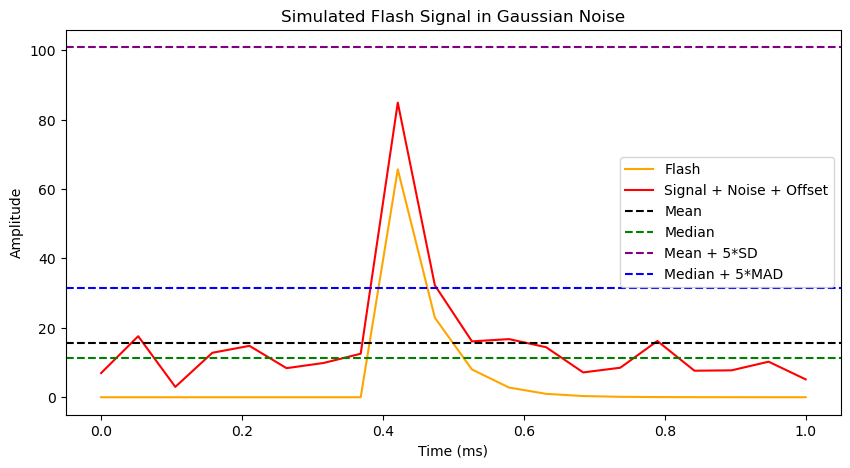

In [61]:
# Simulate 1D flash against Gaussian noise background
fps = 20.0            # Frames per second
block_duration = 1.0  # Duration of block in seconds
nt = int(fps * block_duration)  # Number of time points
sigma_n = 5.0  # Standard deviation of noise
sensor_offset = 10.0  # Sensor offset
A = 100.0       # Amplitude of flash
tau = 0.05      # Time constant of flash decay (seconds)
t0 = 0.4        # Flash start time (seconds)

# Time vector in seconds
t = npx.linspace(0, block_duration, nt)  # Time vector in seconds

# Generate noise
noise = npx.random.normal(0, sigma_n, t.shape)

# Generate flash signal
flash = npx.zeros_like(t)
pre_flash_indices = t < t0
post_flash_indices = t >= t0
flash[post_flash_indices] = A * npx.exp(-(t[post_flash_indices] - t0) / tau)

# Noisy flash signal
signal = noise + flash + sensor_offset

# Clip signal to be non-negative
signal = npx.clip(signal, 0, None)

# Calculate temporal median and MAD of noisy signal
tmedian = npx.median(signal)
tmad = npx.median(npx.abs(signal - tmedian))
tmean = npx.mean(signal)
tstd = npx.std(signal)

# Detection threshold: median + alpha * MAD
alpha = 5.0
rthresh = tmedian + alpha * tmad
thresh = tmean + alpha * tstd

# Plot the results and overlay the temporal median + 2 * MAD
plt.figure(figsize=(10, 5))

if cuda_available:
    t = t.get()
    noise = noise.get()
    flash = flash.get()
    signal = signal.get()
    tmedian = tmedian.get()
    rthresh = rthresh.get()
    thresh = thresh.get()

plt.plot(t, flash, label='Flash', color='orange')
plt.plot(t, signal, label='Signal + Noise + Offset', color='red')
plt.axhline(tmean, color='black', linestyle='--', label='Mean')
plt.axhline(tmedian, color='green', linestyle='--', label='Median')
plt.axhline(thresh, color='purple', linestyle='--', label='Mean + 5*SD')
plt.axhline(rthresh, color='blue', linestyle='--', label='Median + 5*MAD')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Simulated Flash Signal in Gaussian Noise')
plt.legend()
plt.show()

## Synthetic flash in real video

Loaded video shape: 32 x 480 x 720


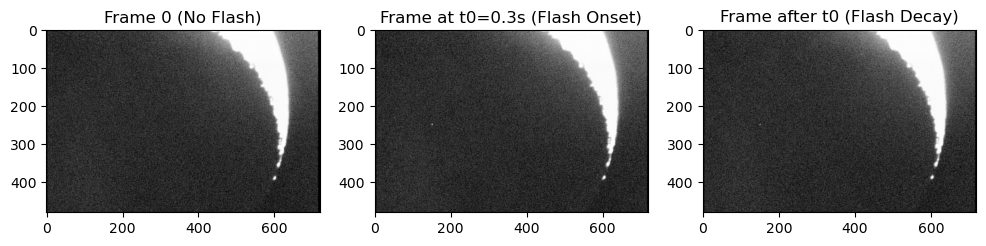

In [62]:
# Load first 32 frames of the ALFI demo AVI video
video_path = "../data/test_video.avi"

# Force FPS to 20 for consistency
fps = 20.0  # Frames per second

# Read video frames using OpenCV
cap = cv2.VideoCapture(video_path)
frames = []
num_frames_to_load = 32
for i in range(num_frames_to_load):
    ret, frame = cap.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray_frame)
cap.release()
signal_block = npx.array(frames)

# Should be (num_frames, height, width)
nt, ny, nx = signal_block.shape
print(f"Loaded video shape: {nt} x {ny} x {nx}")

# Simulate a spatial Gaussian, temporal exponential flash in the video data
flash_sigma_xy = 1.5            # Spatial sigma of Gaussian flash in pixels
flash_amp = 150.0               # Amplitude of flash (8-bit scale)
flash_tau = 0.150               # Time constant of typical LIF (150 ms)
flash_x0, flash_y0 = 150, 250   # Flash center in pixels
flash_t0 = 0.3                  # Flash start time (seconds)

# Create spatial grid
x = npx.arange(nx)
y = npx.arange(ny)
X, Y = npx.meshgrid(x, y)

# Time vector in seconds
t = npx.arange(nt) / fps

# Generate synthetic flash signal over space and time
signal_flash = npx.zeros_like(signal_block)
for i, t_i in enumerate(t):
    if t_i >= flash_t0:
        spatial_component = flash_amp * npx.exp(-(((X - flash_x0) ** 2 + (Y - flash_y0) ** 2) / (2 * flash_sigma_xy ** 2)))
        temporal_component = npx.exp(-(t_i - flash_t0) / flash_tau)
        signal_flash[i] = spatial_component * temporal_component

# Add flash 
signal = npx.asarray(signal_block + signal_flash)

# Clip signal to range [0, 255]
s = npx.clip(signal, 0, 255)

if cuda_available:
    plt_s = signal.get()
else:
    plt_s = signal

# Display a few frames of the simulated data
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(plt_s[0], cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Frame 0 (No Flash)')
axes[1].imshow(plt_s[int(fps * flash_t0)], cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f'Frame at t0={flash_t0}s (Flash Onset)')
axes[2].imshow(plt_s[int(fps * flash_t0)+1], cmap='gray', vmin=0, vmax=255)
axes[2].set_title('Frame after t0 (Flash Decay)')
plt.show()

## Detection core
- use robust estimate of global
Use drop-in CuPy acceleration of numpy and scipy functions

In [ ]:
# Calculate temporal median and MAD of noisy signal at each pixel
t0 = time.perf_counter()
s_tmed = npx.median(signal, axis=0)
print(f"tMedian computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

t0 = time.perf_counter()
s_tmad = npx.median(npx.abs(signal - s_tmed), axis=0)
print(f"tMAD computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

# Calculate temporal mean and SD of noisy signal at each pixel
t0 = time.perf_counter()
s_tmean = npx.mean(signal, axis=0)
print(f"tMean computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

t0 = time.perf_counter()
s_tstd = npx.std(signal, axis=0)
print(f"tSD computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

tMedian computed in 103.62 ms
tMAD computed in 236.10 ms
tMean computed in 6.51 ms
tSD computed in 51.09 ms
Max filter footprint size: 14 x 14
Exclude mask dilation in 3.17 ms
Robust mask dilation in 3.36 ms


### Compare mean/SD and median/MAD masking

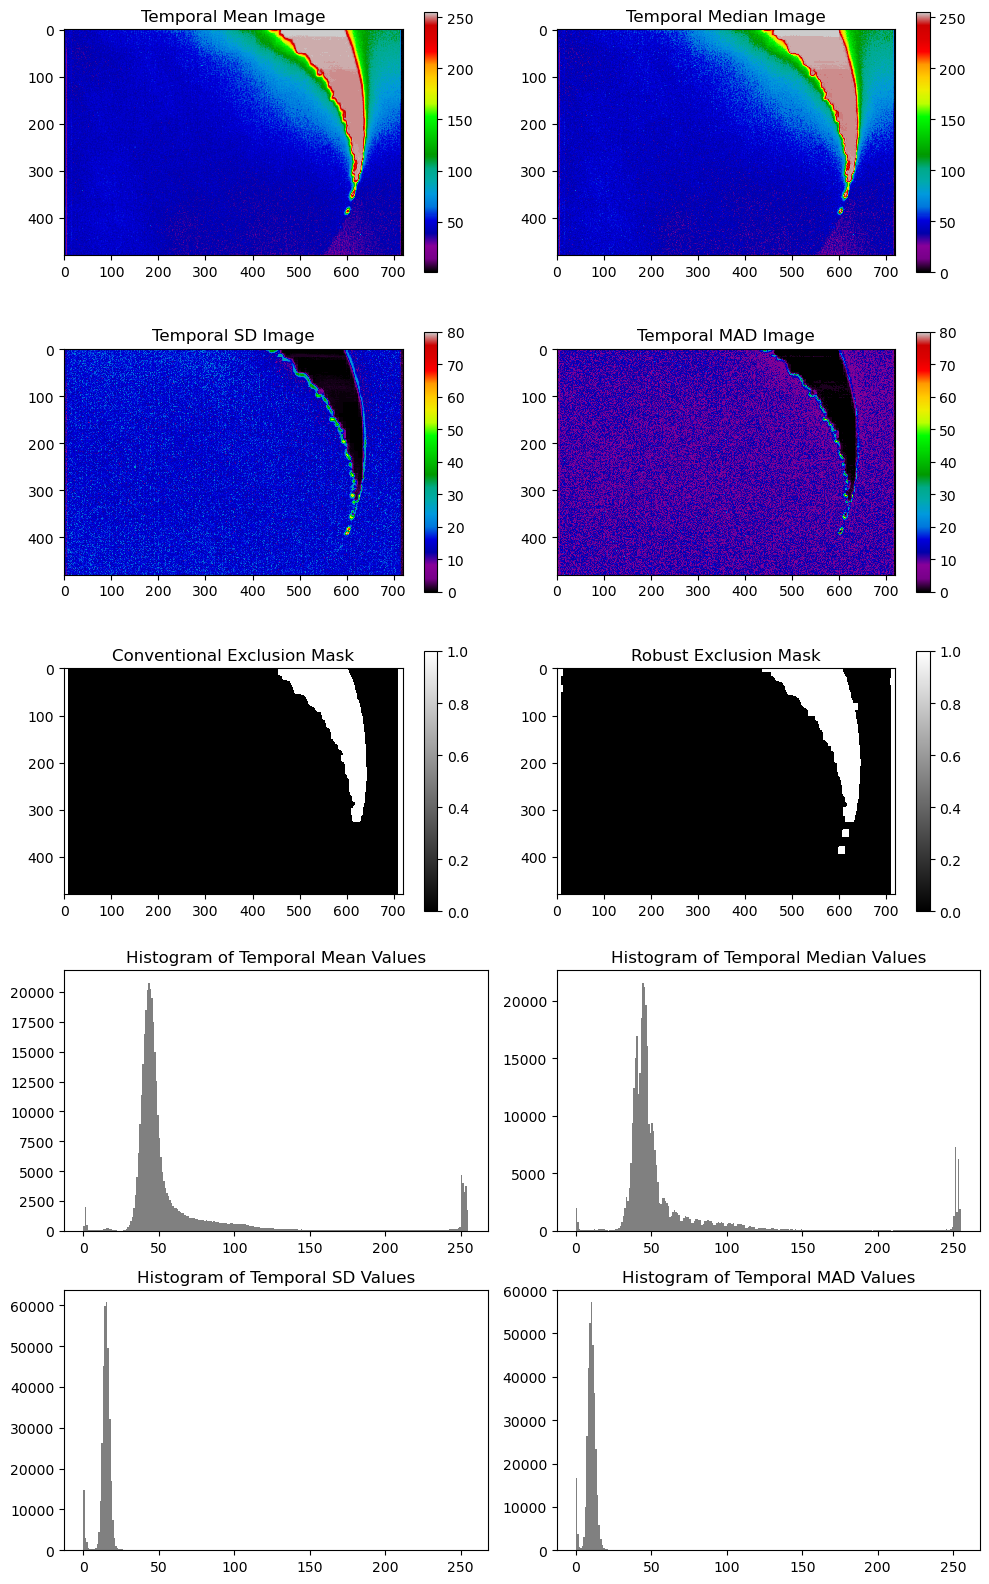

In [ ]:
# Display limits for MAD and SD images
madsd_max = 50

# Plot temporal median and MAD images and signal histograms
if cuda_available:
    plt_s_tmean = s_tmean.get()
    plt_s_tstd = s_tstd.get()
    plt_s_tmed = s_tmed.get()
    plt_s_tmad = s_tmad.get()
else:
    plt_s_tmean = s_tmean
    plt_s_tstd = s_tstd
    plt_s_tmed = s_tmed
    plt_s_tmad = s_tmad

fig, axs = plt.subplots(2, 2, figsize=(10, 16))

pp = axs[0, 0].imshow(plt_s_tmean, cmap='nipy_spectral', interpolation='nearest')
axs[0, 0].set_title('Temporal Mean Image')
fig.colorbar(pp, ax=axs[0, 0])

pp = axs[1, 0].imshow(plt_s_tstd, cmap='nipy_spectral', interpolation='nearest', vmax=80)
axs[1, 0].set_title('Temporal SD Image')
fig.colorbar(pp, ax=axs[1, 0])

pp = axs[0, 1].imshow(plt_s_tmed, cmap='nipy_spectral', interpolation='nearest')
axs[0, 1].set_title('Temporal Median Image')
fig.colorbar(pp, ax=axs[0, 1])

pp = axs[1, 1].imshow(plt_s_tmad, cmap='nipy_spectral', interpolation='nearest', vmax=80)
axs[1, 1].set_title('Temporal MAD Image')
fig.colorbar(pp, ax=axs[1, 1])

plt.tight_layout()
plt.show()

#### SD and MAD distributions

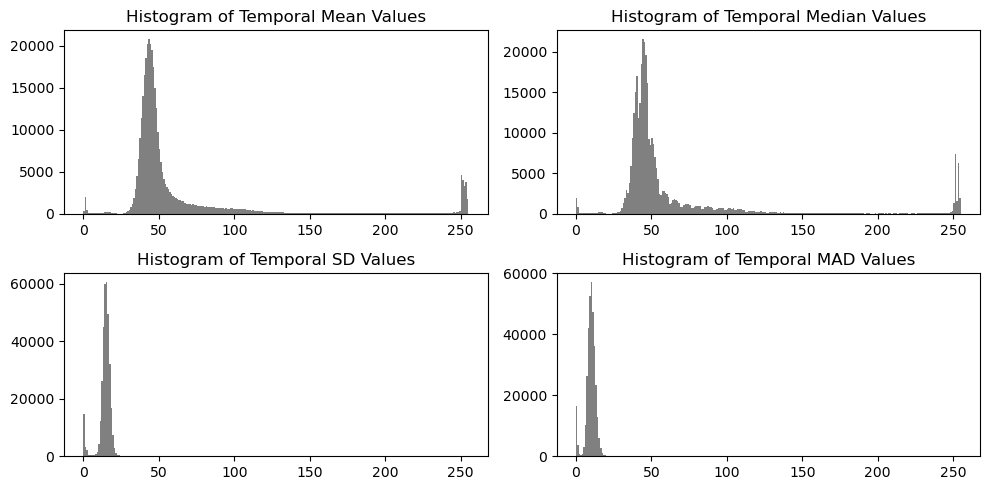

In [ ]:
# Pixel exclusion mask thresholding based on SD or MAD distribution
# High or low clipped voxels (~0 and ~255) have very low variance

sd_p99 = npx.percentile(s_tstd, 99.0)
mad_p99 = npx.percentile(s_tmad, 99.0)

plt_sd_bins = npx.linspace(0, sd_p99, 100)
plt_mad_bins = npx.linspace(0, mad_p99, 100)

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

f_mean, bins_mean, _ = axs[0, 0].hist(plt_s_tmean.flatten(), bins=plt_hist_bins, color='gray')
axs[0, 0].set_title('Histogram of Temporal Mean Values')

f_std, bins_std, _ = axs[1, 0].hist(plt_s_tstd.flatten(), bins=plt_hist_bins, color='gray')
axs[1, 0].set_title('Histogram of Temporal SD Values')

f_med, bins_med, _ = axs[0, 1].hist(plt_s_tmed.flatten(), bins=plt_hist_bins, color='gray')
axs[0, 1].set_title('Histogram of Temporal Median Values')

f_mad, bins_mad, _ = axs[1, 1].hist(plt_s_tmad.flatten(), bins=plt_hist_bins, color='gray')
axs[1, 1].set_title('Histogram of Temporal MAD Values')

plt.tight_layout()
plt.show()

In [ ]:
# Create conventional and robust pixel masks
exclude_mask = s_tstd < 3
robust_mask = s_tmad < 3

# Local maximum filter over 2% frame size neighborhood
max_dim = max(ny, nx)
k = max(3, int(0.02 * max_dim))  # Ensure at least size 3
footprint = npx.ones((k, k), dtype=npx.uint8)
print(f'Max filter footprint size: {k} x {k}')

t0 = time.perf_counter()
exclude_mask = spndx.maximum_filter(exclude_mask.astype(npx.uint8), footprint=footprint) > 0
print(f"Exclude mask dilation in {(time.perf_counter() - t0)*1e3:.2f} ms")

t0 = time.perf_counter()
robust_mask = spndx.maximum_filter(robust_mask.astype(npx.uint8), footprint=footprint) > 0
print(f"Robust mask dilation in {(time.perf_counter() - t0)*1e3:.2f} ms")

In [ ]:

pp = axs[2, 0].imshow(plt_exclude_mask, cmap='gray', interpolation='nearest')
axs[2, 0].set_title('Conventional Exclusion Mask')
fig.colorbar(pp, ax=axs[2, 0])

pp = axs[2, 1].imshow(plt_robust_mask, cmap='gray', interpolation='nearest')
axs[2, 1].set_title('Robust Exclusion Mask')
fig.colorbar(pp, ax=axs[2, 1])


Masked Gaussian filtering computed in 16.81 ms


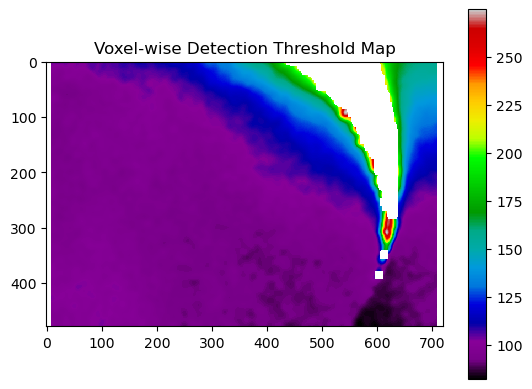

In [65]:
# Create a 2D spatial threshold map from the temporal median and MAD
alpha = 5.0  # Threshold scaling factor
thresh_map = s_tmed + alpha * s_tmad

# Masked gaussian filtering to smooth threshold map while ignoring NaNs
def masked_gaussian_filter(image, mask, sigma):
    """Apply Gaussian filter to image while ignoring masked values."""
    image_filled = npx.where(mask, 0, image)
    filtered_image = spndx.gaussian_filter(image_filled, sigma=sigma)
    normalization = spndx.gaussian_filter((~mask).astype(npx.float32), sigma=sigma)
    normalization = npx.where(normalization == 0, npx.nan, normalization)
    return filtered_image / normalization

t0 = time.perf_counter()
thresh_map = masked_gaussian_filter(thresh_map, mad_mask, sigma=5.0)
print(f"Masked Gaussian filtering computed in {(time.perf_counter() - t0)*1e3:.2f} ms")

# Reapply MAD mask to threshold map
thresh_map = npx.where(mad_mask, npx.nan, thresh_map)

if cuda_available:
    plt_thresh_map = thresh_map.get()
else:
    plt_thresh_map = thresh_map

plt.imshow(plt_thresh_map, cmap='nipy_spectral', interpolation='nearest')
plt.title('Voxel-wise Detection Threshold Map')
plt.colorbar()
plt.show()

Final threshold scale factor: 1.50
Total candidate detections: 69


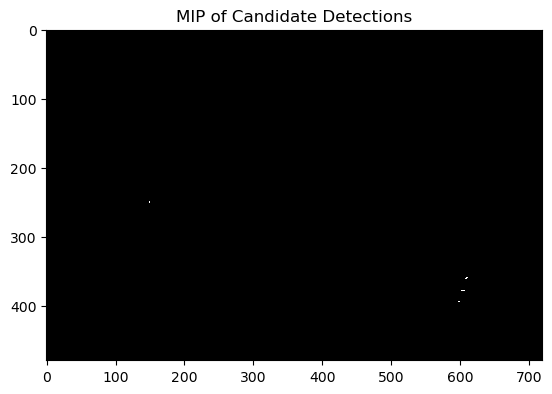

In [66]:
# Threshold the signal to create candidate anomaly detections
thresh = npx.expand_dims(thresh_map, axis=0)
suprathreshold = signal >= thresh

# Iteratively adjust threshold multiplier upwards until < 50 detections found
max_detections = 100
thresh_scale = 1.0
total_detections = npx.sum(suprathreshold)

while total_detections > max_detections:
    thresh_scale += 0.1
    suprathreshold = signal >= thresh * thresh_scale
    total_detections = npx.sum(suprathreshold)

print(f"Final threshold scale factor: {thresh_scale:.2f}")
print(f"Total candidate detections: {total_detections}")

# Display MIP of candidate detections
detection = suprathreshold.astype(npx.uint8)
detection_tmip = npx.max(detection, axis=0)
if cuda_available:
    d_tmip = detection_tmip.get()
else:
    d_tmip = detection_tmip

plt.imshow(d_tmip, cmap='gray', interpolation='nearest')
plt.title('MIP of Candidate Detections')
plt.show()

In [67]:
# Find connected components in 3D detection block
t0 = time.perf_counter()
strel6 = spndx.generate_binary_structure(3, 1)
labels, num_features = spndx.label(detection, structure=strel6)
print(f"Connected components labeling computed in {(time.perf_counter() - t0)*1e3:.2f} ms")
print(f"Number of detected components: {num_features}")

min_area_pix = 4
max_area_pix = 100
min_duration_secs = 0.05
max_duration_secs = 0.25

anomaly_list = []

for l in range(1, num_features + 1):

    # Find bounding box of component l
    component_indices = npx.where(labels == l)
    bb_t_min, bb_t_max = int(npx.min(component_indices[0])), int(npx.max(component_indices[0])+1)
    bb_y_min, bb_y_max = int(npx.min(component_indices[1])), int(npx.max(component_indices[1])+1)
    bb_x_min, bb_x_max = int(npx.min(component_indices[2])), int(npx.max(component_indices[2])+1)

    # Center of bounding box
    com_y, com_x = (bb_y_min + bb_y_max) / 2, (bb_x_min + bb_x_max) / 2

    # Calculate spatial area and temporal duration of component l
    area_pix = (bb_y_max - bb_y_min) * (bb_x_max - bb_x_min)
    duration_secs = (bb_t_max - bb_t_min) / fps

    candidate = (area_pix >= min_area_pix and area_pix <= max_area_pix and
                 duration_secs >= min_duration_secs and duration_secs <= max_duration_secs)
    
    if candidate:

        this_anomaly = {
            'label': l,
            't_min': bb_t_min,
            't_max': bb_t_max,
            'y_min': bb_y_min,
            'y_max': bb_y_max,
            'x_min': bb_x_min,
            'x_max': bb_x_max,
            'com_x': com_x,
            'com_y': com_y,
            'area_pix': area_pix,
            'duration_secs': duration_secs
        }

        anomaly_list.append(this_anomaly)

# Convert to dataframe for easier viewing
anomaly_df = pd.DataFrame(anomaly_list)
print(anomaly_df)

Connected components labeling computed in 30.74 ms
Number of detected components: 8
   label  t_min  t_max  y_min  y_max  x_min  x_max  com_x  com_y  area_pix  \
0      2      0      4    359    362    608    613  610.5  360.5        15   
1      5      6      8    249    252    149    152  150.5  250.5         9   

   duration_secs  
0            0.2  
1            0.1  


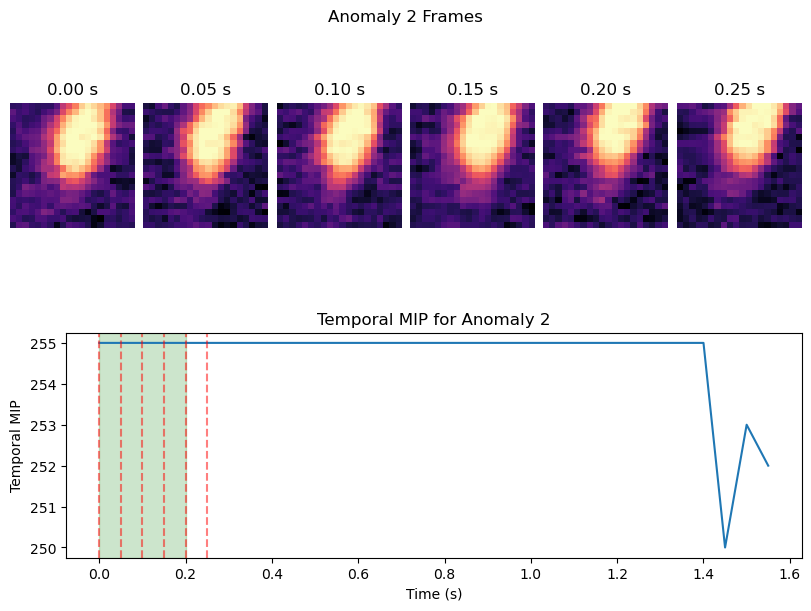

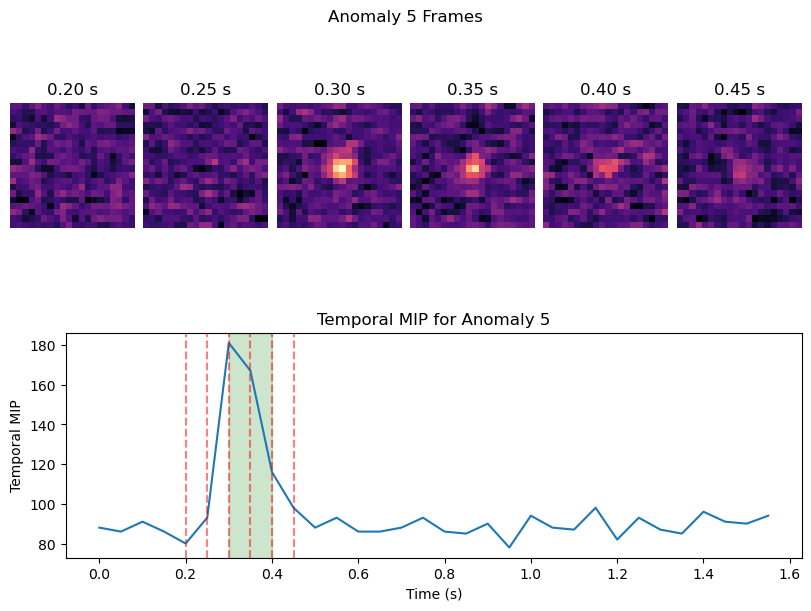

In [68]:
for anomaly in anomaly_list:
    
    l = anomaly['label']
    bb_t_min = anomaly['t_min']
    bb_t_max = anomaly['t_max']
    bb_y_min = anomaly['y_min']
    bb_y_max = anomaly['y_max']
    bb_x_min = anomaly['x_min']
    bb_x_max = anomaly['x_max']
    com_x = anomaly['com_x']
    com_y = anomaly['com_y']

    # Time vector in seconds for bounding box
    bb_t_secs = npx.arange(bb_t_min, bb_t_max) / fps

    # Extract small region around flash CoM
    hw = 10  # Half width of region
    roi_x_min = int(max(com_x - hw, 0))
    roi_x_max = int(min(com_x + hw, signal.shape[2]))
    roi_y_min = int(max(com_y - hw, 0))
    roi_y_max = int(min(com_y + hw, signal.shape[1]))
    flash_region = signal[:, roi_y_min:roi_y_max, roi_x_min:roi_x_max]

    # Create horizontal montage of XY slices through flash region center for two frames before and after flash onset
    montage_t_start = max(bb_t_min - 2, 0)
    montage_t_end = min(bb_t_max + 2, signal.shape[0])
    montage_frames = []
    for frame_idx in range(montage_t_start, montage_t_end):
        slice_xy = flash_region[frame_idx, :, :]
        montage_frames.append(slice_xy)

    # Extract flash MIP profile
    flash_profile = npx.max(npx.max(flash_region, axis=2), axis=1)

    if cuda_available:
        plt_t = t.get()
        plt_flash_profile = flash_profile.get()
        plt_montage = npx.array(montage_frames).get()
    else:
        plt_t = t
        plt_flash_profile = flash_profile
        plt_montage = npx.array(montage_frames)

    # Plot anomaly results in space and time
    # Plot individual frames in as separate axes in row one
    # Plot anomaly temporal profile in row two, spanning all columns

    # Create 2x1 subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(8, 6))

    # Clear subplots
    for ax in axs:
        ax.remove()

    # Create list of subfigures for each row
    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]

    # Add subplots to first row
    subfigs[0].suptitle(f'Anomaly {l} Frames')

    # Create n_roi_frame subplots in top row subfigure
    n_montage_frames = len(montage_frames)

    # Get grand scaling max for montage frames
    grand_max = npx.max(plt_montage)

    axs_toprow = subfigs[0].subplots(nrows=1, ncols=n_montage_frames)
    for col, ax in enumerate(axs_toprow):
        ax.imshow(plt_montage[col], cmap='magma', vmax=grand_max)
        ax.axis('off')
        # Set title to time in seconds
        ax.set_title(f'{plt_t[montage_t_start + col]:.2f} s')

    ax_bottomrow = subfigs[1].subplots(nrows=1, ncols=1)
    ax_bottomrow.plot(plt_t, plt_flash_profile)

    # Add transparent green box to indicate detected flash duration
    ax_bottomrow.axvspan(float(bb_t_min)/fps, float(bb_t_max)/fps, color='green', alpha=0.2)

    # Add box markers for frames shown in montage
    for frame_idx in range(montage_t_start, montage_t_end):
        ax_bottomrow.axvline(plt_t[frame_idx], color='red', linestyle='--', alpha=0.5)

    ax_bottomrow.set_xlabel('Time (s)')
    ax_bottomrow.set_ylabel('Temporal MIP')
    ax_bottomrow.set_title(f'Temporal MIP for Anomaly {l}')

    plt.show()